# Обучение модели

Оценив размер датасета и примерную архитектуру будущей нейросети, я понял, что возможностей моего скромного ноутбука не хватит, чтобы эффективно обучить модель. Поэтому я отправился на Kaggle, чтобы воспользоваться любезно предоставляемой там видеокартой Nvidia Tesla P100.

Итак, для начала импортируем необходимые библиотеки. Для работы с нейросетями я использую TensorFlow/Keras, для предобработки текста - SpaCy, а для векторизации - GloVe с размерностью 100, обученный на текстах википедии и датасете Gigaword.

In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import shutil
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Reshape, Dropout, LSTM
from keras.optimizers import Adam

import spacy
import gensim.downloader as api
import re

import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")
glove = api.load("glove-wiki-gigaword-100")

/kaggle/input/imdbpreproccesed/full_df.csv


Скачаем датасет, удалим из него лишние unsupervised данные, бесполезные для обучения модели, и разобьем данные на тренировочный, валидационный и тестовый сеты.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file(origin=url, untar=True, 
                                  cache_dir='/imdbdataset', cache_subdir='')

dataset_dir = os.path.dirname(dataset)

84125825/84125825 [==============================] - 1s 0us/step


In [4]:
dataset_dir = os.path.join(dataset_dir, 'aclImdb')

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'unsup',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt',
 'urls_pos.txt',
 'pos']

In [6]:
shutil.rmtree(os.path.join(train_dir, 'unsup'))

In [7]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['neg', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'pos']

In [8]:
seed = 0

raw_train_ds = keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=None, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_valid_ds = keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=None, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=None)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Для удобства предобработки сделаем из наших сетов пандовские датафреймы и соединим их в одну таблицу - full_df.

In [9]:
def create_dataframe(raw):
    texts = []
    labels = []
    for text, label in raw:
        texts.append(text.numpy().decode('utf-8'))
        labels.append(label.numpy())

    df = pd.DataFrame(labels, texts).reset_index().rename({'index': 'text', 0: 'rating'}, axis=1)
    return df

In [10]:
train_df = create_dataframe(raw_train_ds)
valid_df = create_dataframe(raw_valid_ds)
test_df = create_dataframe(raw_test_ds)

In [11]:
full_df = pd.concat([train_df, valid_df, test_df])
full_df.head()

,text,rating
0,This is exactly the type of film that frustrat...,0
1,I definitely recommend reading the book prior ...,1
2,"Sloppily directed, witless comedy that suppose...",0
3,Inspired at least a little by Ivy Benson & Her...,1
4,Spirit is a unique and original look at wester...,1


Теперь поработаем с входными данными. Во-первых, очистим тексты от эмодзи и тегов. Затем приведем все строки к нижнему регистру.
Для оптимизации обучения нейросети и для сокращения потребляемой памяти удалим из текстов наиболее употребляемые слова, которые не влияют на характеристику текста: это местоимения, союзы, предлоги и т.д. В библиотеке SpaCy есть такой список слов для исключения.
И в заключении приведем все слова к их первоначальной форме - лемматизируем. Это тоже сократит объём нашего словаря.

Напишем для этого следующую функцию:

In [12]:
stopwords = nlp.Defaults.stop_words
def normalize_text(text):
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    unemoji = emoji_pattern.sub(r'',text)
    
    tag_pattern = re.compile('<.*?>')
    untag = tag_pattern.sub(r'', unemoji)
    lowercase = untag.lower()
    
    no_stopwords = ' '.join([word for word in lowercase.split() if word not in stopwords])
    lemmas = ' '.join([word.lemma_ for word in nlp(no_stopwords)])
    
    return lemmas

Отлично, теперь применим эту функцию к полному датасету. Это заняло у меня около получаса, поэтому результат я сохранил в файл *full_df.csv* и впоследствии, например, для анализа, я обращался к уже предобработанным данным.

In [17]:
full_df.text = full_df.text.map(normalize_text)
#full_df.to_csv('full_df.csv')
#full_df = pd.read_csv('/kaggle/input/imdbpreproccesed/full_df.csv', 
#                      index_col='Unnamed: 0')
full_df.head()

,text,rating
0,"like monster movie , generally . implausible s...",0
1,bad movie . robin williams fit like rhino fit ...,0
2,1986 movie accident tv night . 6 year old . si...,1
3,"big fan martial art movie , video shop nearly ...",1
4,film screen night austin paramount theater sxs...,1


Проверим, что ничего не потерялось :)

In [18]:
len(full_df)

50000

Хорошо, теперь перейдем от букв к цифрам. Tokenizer из библиотеки Keras присваивает каждому слову из наших текстов уникальный номер. В результате текст становится последовательностью чисел.

In [19]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(full_df.text)
vocab_size = len(tokenizer.word_index) + 1
tokenized_text = tokenizer.texts_to_sequences(full_df.text)
print(tokenized_text[0])

[3, 375, 1, 1023, 3150, 448, 102, 3, 1, 3150, 448, 33, 420, 6, 3, 8540, 91, 19, 112, 470, 5612, 3, 29182, 15, 67, 13, 267, 2120, 102, 23, 404, 110, 1284, 52391, 785, 324, 119, 12, 1366, 2198, 422, 13065, 2198, 22, 737, 563, 34, 3, 8, 1221, 58, 9319, 681, 67, 37, 404, 107, 1436, 69, 25278, 2218, 3, 1048, 14, 5612, 21, 95, 13065, 556, 261, 1114, 2690, 1680, 121, 2218, 22, 1, 404, 261, 3150, 261, 470, 2690, 1594, 5612, 260, 2120, 216, 404, 13, 267, 179, 188, 7, 692, 905, 862, 2218, 893, 22606]


Чтобы отправить тексты в нейросеть, нужно, чтобы длина всех текстов была одинаковой. Приведем их к медианной длине всех текстов, представленных в датасете. 
Используем для этого утилиту Keras pad_sequences, которая добавит в конец текста нули, если он по длине меньше, чем медиана, а если текст больше, то обрежет до необходимых размеров.

In [20]:
max_length = int(np.median(full_df.text.str.len()))
padded_text = pad_sequences(tokenized_text, maxlen=max_length, padding='post')
print(*padded_text[0])

3 375 1 1023 3150 448 102 3 1 3150 448 33 420 6 3 8540 91 19 112 470 5612 3 29182 15 67 13 267 2120 102 23 404 110 1284 52391 785 324 119 12 1366 2198 422 13065 2198 22 737 563 34 3 8 1221 58 9319 681 67 37 404 107 1436 69 25278 2218 3 1048 14 5612 21 95 13065 556 261 1114 2690 1680 121 2218 22 1 404 261 3150 261 470 2690 1594 5612 260 2120 216 404 13 267 179 188 7 692 905 862 2218 893 22606 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

И наконец, построим матрицу эмбеддингов. Каждому слову в нашем словаре сопоставим векторное представление из GloVe.

In [21]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    try:
        embedding_matrix[i] = glove.get_vector(word)
    except:
        pass

"Расклеим" полный датасет обратно в тренировочный, валидационный и тестовый, и приступим к обучению нейросети.

In [68]:
train_data = padded_text[:20000]
train_labels = full_df.rating[:20000]

valid_data = padded_text[20000:25000]
valid_labels = full_df.rating[20000:25000]

test_data = padded_text[25000:]
test_labels = full_df.rating[25000:]

# Обучение

Чтобы модель могла усвоить сложные взаимосвязи, но при этом обучалась сравнительно быстро, я выбрал следующую архитектуру НС:

In [87]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 548, 100)          9199900   
                                                                 
 dropout_9 (Dropout)         (None, 548, 100)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 544, 64)           32064     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 136, 64)          0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                     

Начнем обучение!

In [88]:
history = model.fit(train_data, train_labels, epochs=20, validation_data=(valid_data, valid_labels))

Epoch 1/20
625/625 [==============================] - 10s 12ms/step - loss: 0.6934 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 2/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 3/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6937 - accuracy: 0.5031 - val_loss: 0.7226 - val_accuracy: 0.4980
Epoch 4/20
625/625 [==============================] - 8s 12ms/step - loss: 0.6946 - accuracy: 0.5013 - val_loss: 0.6937 - val_accuracy: 0.4980
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6937 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.5018
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6935 - accuracy: 0.5009 - val_loss: 0.6938 - val_accuracy: 0.5014
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6513 - accuracy: 0.6072 - val_loss: 0.5523 - val_accuracy: 0.741

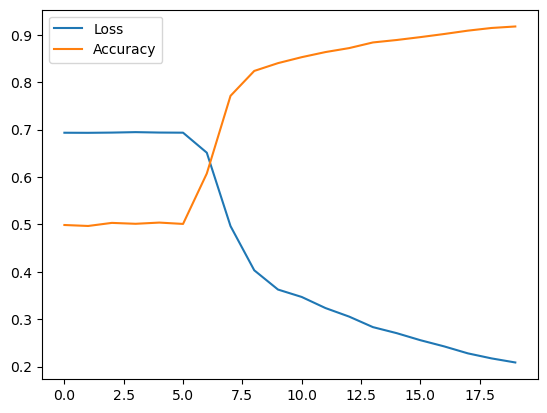

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['Loss', 'Accuracy'])

Так выглядит график обучения нейросети после 20 эпох. После 20 эпох данная модель начинает переобучаться, точность на валидационной выборке падает, поэтому следует остановиться.

Сохраним обученную модель и токенайзер для использования непосредственно в приложении.

In [90]:
model.save('imdbratings.h5')
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)